# USDA Food Desert definition 
(based on Characteristics and Influential Factors of Food Deserts)  

https://www.ers.usda.gov/publications/pub-details?pubid=45017

## A census bloc is a food desert if it is both:
1. **Low-Income** (poverty ≥20%)
2. And **Low-Access** (access >1 mile (urban) or >10 miles (rural) from a supermarket)

In [58]:
import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from dataprocessing import get_blockgroupshape, get_foodswamp_data, get_blockgroup_data

In [59]:
# importing dfs
blockgroup_shapefile = get_blockgroupshape()
food_swamp_df = get_foodswamp_data()
blockgroup_data_df = get_blockgroup_data()

In [60]:
USDA_def = pd.merge(blockgroup_data_df, blockgroup_shapefile,left_on='Geo Index', right_on='GEOIDFQ', how='inner')
#print(len(USDA_def),len(blockgroup_data_df),len(blockgroup_shapefile))

In [61]:
# poverty_le20 flag
USDA_def['poverty_le20'] = USDA_def['Percent Poverty Level'].apply(lambda x: 1 if x >= 0.20 else 0)
# low_access flag:
USDA_def['low_access'] = (
    ((USDA_def['Classification'] == 'Urban') & (USDA_def['Distance_mi'] > 1)) |
    ((USDA_def['Classification'] == 'Rural') & (USDA_def['Distance_mi'] > 10))).astype(int)
# USDA definition flag
USDA_def['USDA_def_flag'] = ((USDA_def['poverty_le20'] == 1) & (USDA_def['low_access'] == 1)).astype(int)

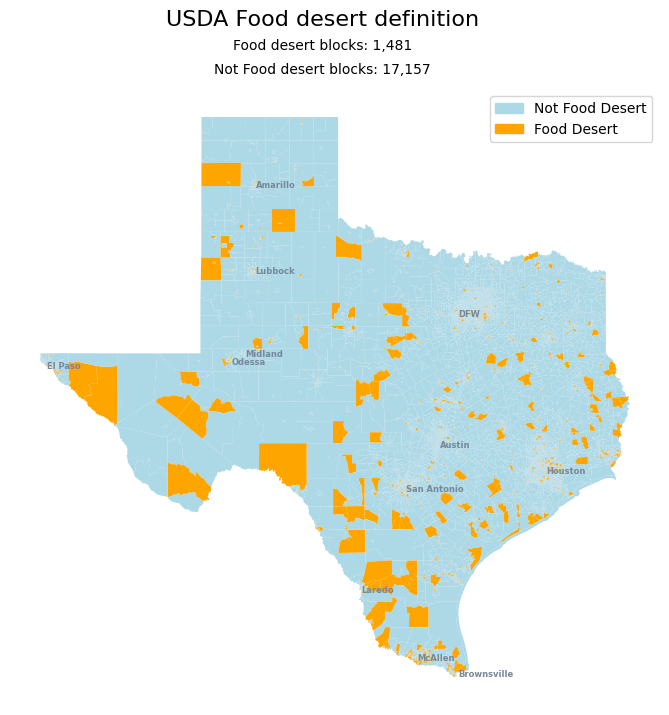

In [115]:
FD_cnt = (USDA_def['USDA_def_flag'] == 1).sum()
NFD_cnt =  (USDA_def['USDA_def_flag'] == 0).sum()

# converting  USDA_def to a GeoDataFrame 
USDA_def = gpd.GeoDataFrame(USDA_def, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 8))
cmap = ListedColormap(['lightblue', 'orange'])  # green for 0, lightcoral (red) for 1

USDA_def.plot(column='USDA_def_flag', cmap=cmap, legend=False, ax=ax)
ax.set_axis_off()

# create custom legends using patches 
not_fd_patch = mpatches.Patch(color='lightblue', label='Not Food Desert')
fd_patch = mpatches.Patch(color='orange', label='Food Desert')

plt.legend(handles=[not_fd_patch, fd_patch], loc='upper right')

# adding big cities
texas_cities = {
    'Houston': (-95.3698, 29.7604),
    'DFW': (-97.3308, 32.7555),
    'Austin': (-97.7431, 30.2672),
    'San Antonio': (-98.4936, 29.4241),
    'El Paso': (-106.4850, 31.7619),
    'Laredo': (-99.4803, 27.5036),
    'Brownsville': (-97.3208, 25.9017),
    'McAllen': (-98.2360, 26.2034),
    'Amarillo': (-101.8313, 35.2219),
    'Lubbock': (-101.8552, 33.5779),
    'Odessa': (-102.3676, 31.8457),
    'Midland': (-102.0779, 32.0000)}

for city, (lon, lat) in texas_cities.items():
    ax.text(lon, lat, city,
            fontsize=6,
            fontweight='bold',
            color='lightslategray',
            ha='left',
            va='center', 
            bbox=dict(facecolor='none', edgecolor='none', alpha=0.4))

fig.suptitle('USDA Food desert definition', fontsize=16, y=0.98)
fig.text(0.5, 0.93, f'Food desert blocks: {FD_cnt:,}', ha='center', fontsize=10)
fig.text(0.5, 0.90, f'Not Food desert blocks: {NFD_cnt:,}', ha='center', fontsize=10)

plt.show()